# Project 4: Driver Drowsiness detection

# Description

A self-driving car or autonomous car is a vehicle that uses a combination of sensors, cameras, radar, and artificial intelligence (AI) to travel between destinations without a human operator. One of the features of such an advanced card is driver drowsiness detection. Driver drowsiness detection is a car safety technology that helps prevent accidents caused by the driver getting drowsy. Various studies have suggested that around 20% of all road accidents are fatigue-related, up to 50% on certain roads. 

There are various methods that can be used to find the drowsiness of the driver such as Steering pattern monitoring, Vehicle position in lane monitoring, Driver eye/face monitoring, etc.
In this project, the driver face monitoring technique has been used to find the drowsiness.

Dataset source - https://www.kaggle.com/datasets/dheerajperumandla/drowsiness-dataset

This dataset contains images with the various position of the eyes i.e., 

Closed, 
Open,
Yawn, 
no_yawn.


# Methodology  
Driver Drowsiness Detection with Transfer Learning DL Technique

# Deliverable
Train the model for multi class classification approach and identify the class from the folder name of the dataset.

Project Outcomes
● Explore various ways of computer vision methods to predict drowsiness
● Identify various ML and DL approaches to predict drowsiness
● Identify the best DL model to train the data
● Train deep learning model for drowsiness.

# Load Dependencies, Dataset & Visualization of Data

In [42]:

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16 #importing VGG16 model to implement transfer learning 
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import os
import cv2
import tensorflow as tf
import keras

#get the name of all directories from train dataset and printing them
data_label = os.listdir("dataset/train")
data_label

['Closed', 'no_yawn', 'Open', 'yawn']

Read & visulize data in 2d scalar from each direc 

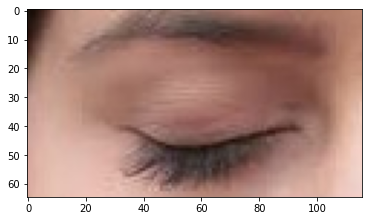

In [22]:
#read & visulize data in 2d scalar from each direc 

plt.imshow(plt.imread("dataset/train/Closed/_7.jpg"))

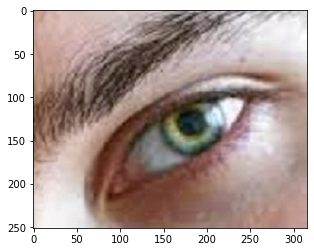

In [23]:
plt.imshow(plt.imread("dataset/train/Open/_9.jpg"))

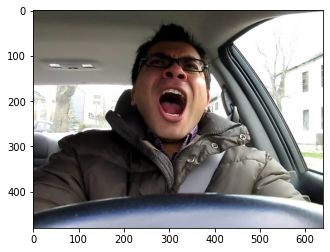

In [24]:
plt.imshow(plt.imread("dataset/train/yawn/38.jpg"))

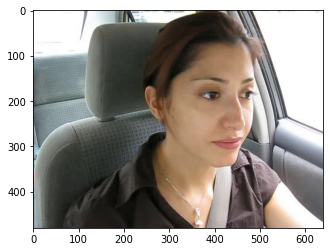

In [25]:
plt.imshow(plt.imread("dataset/train/no_yawn/3.jpg"))

Identify the size of image as an array 

In [30]:
arr = plt.imread("dataset/train/yawn/3.jpg")
arr.shape

(480, 640, 3)

# Data Preparation


Define the classes for following 2 categories:
yawn = class no 0
no_yawn = class no. 1

Remove less meaningful individual image data for above 2 classes by leveraging Haar Feature-based Cascade Classifier from OpenCV for Face ONLY Detection 

In [31]:
def face_for_yawn(direc="dataset/train", face_cas_path="prediction-images/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 224 ## to prepare image size of 224x224
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category) #path to yawn/no_yawn
        class_num1 = categories.index(category) #assiging class no.
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR) #reading images to an array
            face_cascade = cv2.CascadeClassifier(face_cas_path) #loading .xml classifier file
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5) #preparing boundries for detected faces
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2) #draw rectangle for images in an array
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE)) # resize an array for 224x224 scale image
                yaw_no.append([resized_array, class_num1]) #place class numbers 
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


For "closed" & "open" eyes categories, datapoints has less background noise so doesn't need to remove unnecessary image pixel values, however, still requires to categories to following class and resize the image files to align with 1st input layer

Closed = 2
Open = 3

In [28]:
def get_data(dir_path="dataset/train/", face_cas="prediction-images/haarcascade_frontalface_default.xml", eye_cas="../input/prediction-images/haarcascade.xml"):
    data_label = ['Closed', 'Open']
    IMG_SIZE = 224 ## to prepare image size of 224x224
    data = []
    for label in data_label:
        path = os.path.join(dir_path, label)
        class_num = data_label.index(label) #assiging class no.
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR) #reading images to an array
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize an array for 224x224 scale image
                data.append([resized_array, class_num]) 
            except Exception as e:
                print(e)
    return data

In [32]:
data_train = get_data() #calling previously defined function to print the classes


2
3


Creating function to extend the data from face_for_yawn() & get_data() and convert an array. Also defining new variable to store appended data.

In [33]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

new_data = append_data()

0
1
2
3


C:\Users\maulik_upala.LEI\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


Features & label creation and reshaping the feature array equivalent to first input layer of the model

In [35]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
X = X.reshape(-1, 224, 224, 3)
X.shape #Confirming the shape

(1925, 224, 224, 3)

# Data Preprocessing 
Utilizing LabelBinarizer to binarize the label for the classification problem. At training, it converts multi-class labels to binary labels using transform method.


In [36]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y) #Transform to column vector

In [37]:
y = np.array(y) #Preparing label array

In [38]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30 # 70/30 spilt between train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [39]:
len(X_test) #size of X_test set

578

Real-time data augmentation using ImageDataGenerator() which will generate batches of data of tensor image data

In [41]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30) #30deg of random rotation of images with 0.2 of random zoom range
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False) #loads the image dataset in memory and generates batches of augmented data
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Transfer Learning Model Design
Base model = VGG16


In [44]:

IMAGE_SIZE = [224, 224] # re-size the input images

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


for layer in vgg.layers:
  layer.trainable = False #Setting training off for exisiting VGG16 weights to save compute resources

  
folders = glob('Dataset/Train/*') #return a list of dataset classes 
folders

#Adding the Flatten layer 
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# Structure of the model
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Model Compilation

In [45]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


# Model Learning

Fit the model and hyperparameter fine-tuning  

In [18]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))


Epoch 1/50
43/43 [==============================] - 488s 11s/step - loss: 0.4720 - accuracy: 0.8040 - val_loss: 0.0807 - val_accuracy: 0.9291
Epoch 2/50
43/43 [==============================] - 469s 11s/step - loss: 0.2121 - accuracy: 0.9169 - val_loss: 0.1027 - val_accuracy: 0.8979
Epoch 3/50
43/43 [==============================] - 456s 11s/step - loss: 0.1418 - accuracy: 0.9428 - val_loss: 0.0110 - val_accuracy: 0.9533
Epoch 4/50
43/43 [==============================] - 455s 11s/step - loss: 0.1550 - accuracy: 0.9384 - val_loss: 4.9652e-04 - val_accuracy: 0.9187
Epoch 5/50
43/43 [==============================] - 456s 11s/step - loss: 0.1359 - accuracy: 0.9480 - val_loss: 0.0106 - val_accuracy: 0.9619
Epoch 6/50
43/43 [==============================] - 453s 11s/step - loss: 0.1012 - accuracy: 0.9607 - val_loss: 0.0079 - val_accuracy: 0.9654
Epoch 7/50
43/43 [==============================] - 452s 11s/step - loss: 0.0990 - accuracy: 0.9629 - val_loss: 0.0137 - val_accuracy: 0.9671
E

# Model Performance Metrices 

Plotting learning curves for train & test data to identify Model Accuracy & loss/error  

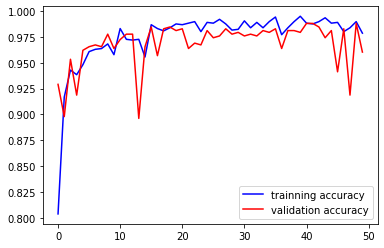

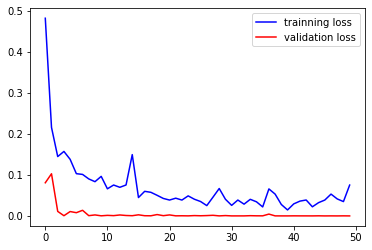

In [20]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

# Saving Model & Prediction
saving model for Inference prediction and performing prediction on Test set

In [56]:
model.save("drowiness_TL.h5")
model.save("drowiness_TL.model")
prediction = np.argmax(model.predict(X_test), axis=-1)
prediction

array([1, 3, 1, 1, 2, 2, 0, 2, 3, 1, 2, 0, 1, 0, 2, 2, 3, 3, 2, 2, 1, 0,
       2, 2, 2, 0, 2, 0, 1, 2, 1, 2, 0, 2, 3, 1, 0, 1, 0, 1, 1, 0, 2, 1,
       2, 2, 0, 2, 2, 2, 2, 2, 1, 0, 0, 1, 2, 2, 2, 2, 1, 1, 0, 2, 0, 2,
       2, 1, 2, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 0, 0, 2, 2, 2,
       1, 2, 0, 3, 0, 0, 1, 0, 0, 2, 1, 0, 3, 0, 1, 2, 2, 2, 2, 0, 2, 1,
       0, 1, 2, 3, 2, 2, 1, 0, 2, 2, 1, 3, 1, 2, 0, 1, 1, 2, 2, 2, 0, 1,
       1, 2, 0, 2, 1, 1, 2, 2, 2, 1, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0,
       2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 3, 0, 2, 2, 0, 2,
       1, 2, 2, 0, 0, 2, 1, 3, 2, 2, 1, 0, 2, 0, 2, 0, 2, 1, 2, 2, 1, 2,
       1, 2, 2, 3, 2, 0, 2, 2, 2, 1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 1, 3, 3,
       2, 2, 2, 2, 0, 1, 2, 2, 3, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 3, 2, 0,
       1, 2, 1, 0, 1, 2, 2, 2, 0, 0, 1, 1, 2, 0, 2, 1, 3, 2, 2, 3, 2, 2,
       2, 2, 0, 3, 3, 1, 0, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 0, 1, 1, 1, 2,
       2, 1, 2, 2, 3, 1, 1, 2, 2, 2, 2, 0, 2, 1, 1,

# Reporting Classification Metrices
Generating classwise performance report

Metrices-  

Precision, recall, f1-score, Support

Classes -

yawn, no_yawn, Closed, Open

In [55]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

ValueError: Found input variables with inconsistent numbers of samples: [578, 1]

# Reference Prediction Function
Define the function to return the class for input image during ineferencing

In [50]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 224
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_TL.h5")

# Prediction Inference Results - Driver Drowsiness Dataset  

## Pre-defined classes
## yawn - 0 
## no_yawn - 1
## Closed - 2
## Open - 3

Experiment - "no_yawn"

In [51]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare("dataset/train/no_yawn/1067.jpg")])
np.argmax(prediction)

1

Experiment - "Closed"

In [52]:
prediction = model.predict([prepare("dataset/train/Closed/_101.jpg")])
np.argmax(prediction)

0

Experiment - "Open"

In [53]:
prediction = model.predict([prepare("dataset/train/Open/_104.jpg")])
np.argmax(prediction)

0